In [24]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

In [25]:
latent_dim = 2
input_dim = 28 * 28
inter_dim = 256

class VAE(nn.Module):
    def __init__(self, input_dim=input_dim, inter_dim=inter_dim, latent_dim=latent_dim):
        super(VAE, self).__init__()

        self.z_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, inter_dim),
            nn.ReLU(),
            nn.Linear(inter_dim, latent_dim * 2),
            # Dont add ReLU anymore!
        )

        self.decoder =  nn.Sequential(
            nn.Linear(latent_dim, inter_dim),
            nn.ReLU(),
            nn.Linear(inter_dim, input_dim),
            nn.Sigmoid(),
        )

    def reparameterise(self, mu, logvar):
        epsilon = torch.randn_like(mu)
        return mu + epsilon * torch.exp(logvar / 2)

    def forward(self, x):
        org_size = x.size()
        batch = org_size[0]
        x = x.view(batch, -1)

        h = self.encoder(x)
        mu, logvar = h.chunk(2, dim=1)
        z = self.reparameterise(mu, logvar)
        recon_x = self.decoder(z).view(size=org_size)

        return recon_x, mu, logvar
    
    def decode(self, z):
        return self.decoder(z).view(-1, 1, 28, 28)

In [26]:
kl_loss = lambda mu, logvar: -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
recon_loss = lambda recon_x, x: F.binary_cross_entropy(recon_x, x, size_average=False)

In [27]:
epochs = 200
batch_size = 128

transform = transforms.Compose([transforms.ToTensor()])
data_train = MNIST('MNIST_DATA/', train=True, download=True, transform=transform)
data_valid = MNIST('MNIST_DATA/', train=False, download=True, transform=transform)

train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(data_valid, batch_size=batch_size, shuffle=False, num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE(input_dim, inter_dim, latent_dim)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Epoch 0
Training loss  550.620 	 Recon  550.612 	 KL  0.007 in Step 0


c:\Users\twelve\.conda\envs\pytorch_gpu\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Training loss  194.923 	 Recon  187.345 	 KL  7.578 in Step 100
Training loss  181.586 	 Recon  175.466 	 KL  6.120 in Step 200
Training loss  184.401 	 Recon  178.980 	 KL  5.421 in Step 300
Training loss  180.530 	 Recon  175.729 	 KL  4.800 in Step 400
Valid loss  173.751 	 Recon  168.837 	 KL  4.914 in epoch 0
Model saved
Epoch 1
Training loss  167.473 	 Recon  162.389 	 KL  5.084 in Step 0
Training loss  176.803 	 Recon  172.067 	 KL  4.736 in Step 100
Training loss  171.387 	 Recon  166.446 	 KL  4.941 in Step 200
Training loss  166.377 	 Recon  161.253 	 KL  5.125 in Step 300
Training loss  165.067 	 Recon  160.031 	 KL  5.036 in Step 400
Valid loss  166.230 	 Recon  161.084 	 KL  5.146 in epoch 1
Model saved
Epoch 2
Training loss  168.586 	 Recon  163.434 	 KL  5.152 in Step 0
Training loss  169.467 	 Recon  164.222 	 KL  5.245 in Step 100
Training loss  169.844 	 Recon  164.919 	 KL  4.925 in Step 200
Training loss  161.312 	 Recon  156.184 	 KL  5.127 in Step 300
Training los

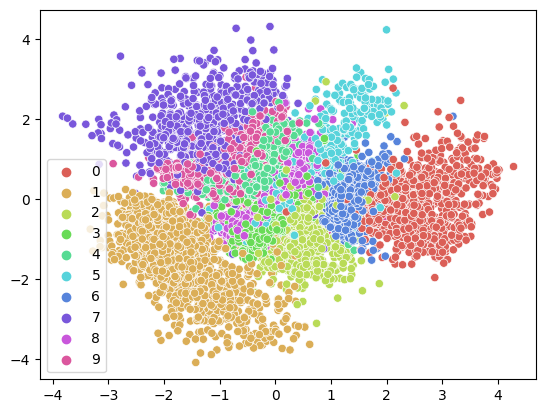

In [28]:
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np
import os
import torchvision.utils as vutils

# 创建保存图片的目录
save_dir = 'saved_images'
os.makedirs(save_dir, exist_ok=True)

best_loss = 1e9
best_epoch = 0

valid_losses = []
train_losses = []


for epoch in range(epochs):
    print(f"Epoch {epoch}")
    model.train()
    train_loss = 0.
    train_num = len(train_loader.dataset)

    for idx, (x, _) in enumerate(train_loader):
        batch = x.size(0)
        x = x.to(device)
        recon_x, mu, logvar = model(x)
        recon = recon_loss(recon_x, x)
        kl = kl_loss(mu, logvar)

        loss = recon + kl
        train_loss += loss.item()
        loss = loss / batch

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if idx % 100 == 0:
            print(f"Training loss {loss: .3f} \t Recon {recon / batch: .3f} \t KL {kl / batch: .3f} in Step {idx}")

    train_losses.append(train_loss / train_num)

    valid_loss = 0.
    valid_recon = 0.
    valid_kl = 0.
    valid_num = len(test_loader.dataset)
    model.eval()

    with torch.no_grad():

        test_latent_vectors = []

        for idx, (x, _) in enumerate(test_loader):
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            recon = recon_loss(recon_x, x)
            kl = kl_loss(mu, logvar)
            loss = recon + kl
            valid_loss += loss.item()
            valid_kl += kl.item()
            valid_recon += recon.item()

            z = model.reparameterise(mu, logvar)
            test_latent_vectors.append(z.cpu().numpy())

        valid_losses.append(valid_loss / valid_num)

        print(f"Valid loss {valid_loss / valid_num: .3f} \t Recon {valid_recon / valid_num: .3f} \t KL {valid_kl / valid_num: .3f} in epoch {epoch}")

        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch

            torch.save(model.state_dict(), 'best_model_mnist')
            print("Model saved")

        sample = torch.randn(64, model.z_dim).to(device)
        sample = model.decode(sample).view(-1, 1, 28, 28).cpu()
        vutils.save_image(sample, os.path.join(save_dir, f'epoch_{epoch}.png'), nrow=8, padding=2, normalize=True)

test_latent_vectors = np.concatenate(test_latent_vectors, axis=0)

# 使用 PCA 将潜在向量降到二维空间
pca = PCA(n_components=2)
pca.fit(test_latent_vectors)
test_latent_vectors_pca = pca.transform(test_latent_vectors)

# 绘制散点图
sns.scatterplot(x=test_latent_vectors_pca[:, 0], y=test_latent_vectors_pca[:, 1], hue=data_valid.targets, palette=sns.color_palette("hls", len(data_valid.classes)))
plt.show()
    

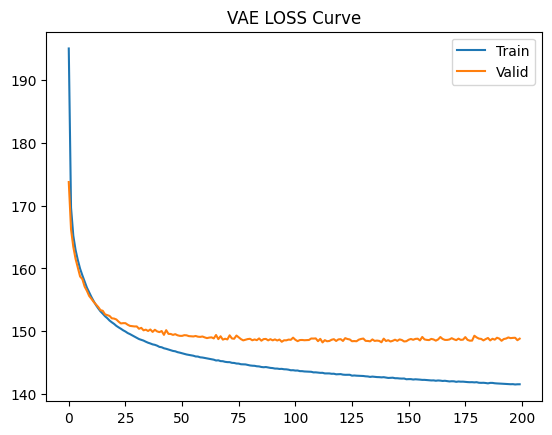

In [32]:
plt.plot(train_losses, label='Train')
plt.plot(valid_losses, label='Valid')
plt.title("VAE LOSS Curve")
plt.legend();

In [30]:
import numpy as np
from scipy.stats import norm

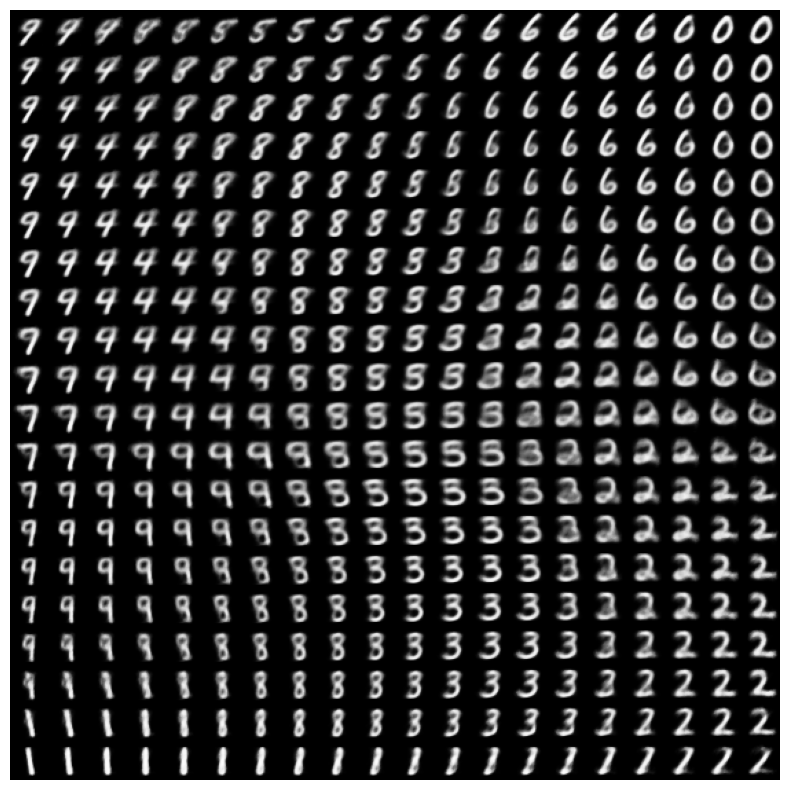

In [31]:
state = torch.load('best_model_mnist')
model = VAE()
model.load_state_dict(state)


n = 20
digit_size = 28

grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))


model.eval()
figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        t = [xi, yi]
        z_sampled = torch.FloatTensor(t)
        with torch.no_grad():
            decode = model.decoder(z_sampled)
            digit = decode.view((digit_size, digit_size))
            figure[
                i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size
            ] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap="Greys_r")
plt.xticks([])
plt.yticks([])
plt.axis('off');